In [1]:
import fsps
import dynesty
import sedpy
import h5py, astropy
import numpy as np
import astroquery
import matplotlib.pyplot as plt
import pandas as pd
import prospect
import numpy as np

# Build an observation

In [2]:
def load_photometry(version, z=0.924, drop_telescope=[], drop_band=[]):
    from sedpy.observate import load_filters
    from prospect.utils.obsutils import fix_obs
    from glob import glob
    #photometry x
    rate = 10**(-0.4*23.9) #uJy to maggies(10**(-0.4*m_AB))
    maggies = pd.read_csv(f'/home/lupengjun/OII_emitter/photometry/output/flux_sum_{version}.csv', index_col=0).drop(drop_telescope, axis=1).drop(drop_band, axis=0).stack().values*rate
    maggerr = pd.read_csv(f'/home/lupengjun/OII_emitter/photometry/output/error_sum_{version}.csv', index_col=0).drop(drop_telescope, axis=1).drop(drop_band, axis=0).stack().values*rate
    #filters
    stack_df = pd.read_csv(f'/home/lupengjun/OII_emitter/photometry/output/flux_sum_{version}.csv', index_col=0).drop(drop_telescope,axis=1).drop(drop_band, axis=0).stack().reset_index()
    filters = stack_df['level_0']
    telescopes = stack_df['level_1']
    filter_list = [glob(f'/home/lupengjun/OII_emitter/data/filter/{telescope}/*{band}*')[0] for telescope, band in zip(telescopes, filters)]
    filters = load_filters(filter_list) #use sedpy to load filters, but change the source code to direct the filter path to mine
    print(filter_list)
    #construct obs dictionary
    obs = dict(wavelength=None, spectrum=None, unc=None, redshift=z, # redshift from z_spec
           maggies=maggies, maggies_unc=maggerr, filters=filters) #only photometry
    obs = fix_obs(obs)
    return obs

In [3]:
obs = load_photometry('homo_ellipse_v1', drop_telescope=['VISTA'], drop_band=['NB0387'])

['/home/lupengjun/OII_emitter/data/filter/HST/ACS_F606W.res', '/home/lupengjun/OII_emitter/data/filter/HST/ACS_F814W.res', '/home/lupengjun/OII_emitter/data/filter/HST/wfc3-F125W.res', '/home/lupengjun/OII_emitter/data/filter/HST/wfc3-F160W.res', '/home/lupengjun/OII_emitter/data/filter/JWST/JWST_NIRCam.F115W.dat', '/home/lupengjun/OII_emitter/data/filter/JWST/JWST_NIRCam.F150W.dat', '/home/lupengjun/OII_emitter/data/filter/JWST/JWST_NIRCam.F277W.dat', '/home/lupengjun/OII_emitter/data/filter/JWST/JWST_NIRCam.F444W.dat', '/home/lupengjun/OII_emitter/data/filter/SUBARU/HSC-G.txt', '/home/lupengjun/OII_emitter/data/filter/SUBARU/HSC-I.txt', '/home/lupengjun/OII_emitter/data/filter/SUBARU/HSC-R.txt', '/home/lupengjun/OII_emitter/data/filter/SUBARU/HSC-Y.txt', '/home/lupengjun/OII_emitter/data/filter/SUBARU/HSC-Z.txt', '/home/lupengjun/OII_emitter/data/filter/SUBARU/Subaru_HSC.IB0945_filter.dat', '/home/lupengjun/OII_emitter/data/filter/SUBARU/Subaru_HSC.NB0527_filter.dat', '/home/lupengju

In [18]:
#check filter data
from sedpy.observate import load_filters
filter_list = ['/home/lupengjun/OII_emitter/data/filter/HST/ACS_F606W.res', '/home/lupengjun/.local/lib/python3.10/site-packages/sedpy/data/filters/acs_wfc_f606w.par']
filters = load_filters(filter_list) #use sedpy to load filters, but change the source code to direct the filter path to mine
print(filters[0].rectangular_width, filters[1].rectangular_width)

1982.5540008211667 1996.5966887014372


# Bulid a model

In [ ]:
from prospect.models.templates import TemplateLibrary

In [29]:
from prospect.models.templates import TemplateLibrary
from prospect.models import priors
from prospect.models import SpecModel
#delayed tau SFH
model_params = TemplateLibrary["parametric_sfh"]
#nebular emission with logU varies
model_params.update(TemplateLibrary["nebular"])
model_params['gas_logu']['isfree'] = True
model_params['gas_logu']['prior'] = priors.TopHat(mini=-4., maxi=-2.)
model_params['add_neb_continuum']['init'] = False #defunction the nebular continuum
#dust extinction
model_params['dust2']['prior'] = priors.TopHat(mini=0., maxi=5.) #uniform prior    dust["Av"] = (0., 5.)                     # Vary Av between 0 and 5 magnitudes
#fixed spectroscopy redshift
model_params["zred"]["init"] = obs["redshift"]
model_params["zred"]["isfree"] = False
###tau, mass, metalicity prior need to be tuned###
model_params['tage']['prior'] = priors.TopHat(mini=0.1, maxi=13.8) #    delayed["age"] = (0.1, 15.)           # Time since SF began: Gyr
model_params['tau']['prior'] = priors.TopHat(mini=0.3, maxi=10.) #    delayed["tau"] = (0.3, 10.)           # Timescale of decrease: Gyr
model_params['mass']['prior'] = priors.LogUniform(mini=1., maxi=1e15)#    delayed["massformed"] = (1., 15.)
model_params['logzsol']['prior'] = priors.TopHat(mini=-2, maxi=0.4)#    delayed["metallicity"] = (0., 2.5)
model = SpecModel(model_params)
print(model)

NameError: name 'obs' is not defined

In [30]:
from prospect.models.templates import TemplateLibrary
TemplateLibrary["parametric_sfh"]

{'zred': {'N': 1,
  'isfree': False,
  'init': 0.1,
  'units': 'redshift',
  'prior': <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=4.0)},
 'mass': {'N': 1,
  'isfree': True,
  'init': 10000000000.0,
  'units': 'Solar masses formed',
  'prior': <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0)},
 'logzsol': {'N': 1,
  'isfree': True,
  'init': -0.5,
  'units': '$\\log (Z/Z_\\odot)$',
  'prior': <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)},
 'dust2': {'N': 1,
  'isfree': True,
  'init': 0.6,
  'units': 'optical depth at 5500AA',
  'prior': <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)},
 'sfh': {'N': 1, 'isfree': False, 'init': 4, 'units': 'FSPS index'},
 'tage': {'N': 1,
  'isfree': True,
  'init': 1,
  'units': 'Gyr',
  'prior': <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)},
 'imf_type': {'N': 1, 'isfree': False, 'init': 2},
 'dust_type': {'N': 1, 'isfree': False, 'init': 0},
 'tau': {'N': 1,
  'isfr

In [5]:
noise_model = (None, None)

# Get a 'Source'

In [1]:
from prospect.sources import CSPSpecBasis
sps = CSPSpecBasis(zcontinuous=1)
print(sps.ssp.libraries)

(b'pdva', b'miles', b'DL07  ')


# Make a prediction

In [43]:
current_parameters = ",".join([f"{p}={v}" for p, v in zip(model.free_params, model.theta)])
print(current_parameters)
spec, phot, mfrac = model.predict(model.theta, obs=obs, sps=sps)
print(phot / obs["maggies"])

mass=10000000000.0,logzsol=-0.5,dust2=0.6,tage=1.0,tau=1.0,gas_logu=-2.0
[ 3.84832497  2.67564595  1.2676187   0.77616402  1.41819989  0.76543039
  0.26227185  0.1626484   8.52768638  3.30877332  4.3465387   3.49270197
  2.3294848   4.01881682  6.69626684  3.71439154  2.9377953   2.25838629
  5.36613513  0.74462723  3.42026841  0.40338269 13.06790996]


# Run a fit

In [8]:
from prospect.fitting import lnprobfn, fit_model
#fitting_kwargs = dict(nlive_init=400, nested_method="rwalk", nested_target_n_effective=1000, nested_dlogz_init=0.05)
output = fit_model(obs, model, sps, optimize=False, dynesty=True, lnprobfn=lnprobfn, noise=noise_model,)
result, duration = output["sampling"]

iter: 3262 | batch: 0 | nc: 1 | ncall: 32027 | eff(%): 10.185 | logz: 221.015 +/-  0.493 | dlogz:  0.000 >  0.020           


done dynesty (initial) in 2010.8784663677216s


iter: 15647 | batch: 19 | nc: 1 | ncall: 109429 | eff(%): 12.784 | loglstar: 238.463 < 248.254 < 246.311 | logz: 221.091 +/-  0.167 | stop:  1.007     

done dynesty (dynamic) in 4149.7487823963165s


In [9]:
from prospect.io import write_results as writer
hfile = "./default_homo_ellipse_v1_dynesty.h5"
writer.write_hdf5(hfile, {}, model, obs,
                 output["sampling"][0], None,
                 sps=sps,
                 tsample=output["sampling"][1],
                 toptimize=0.0)

/home/lupengjun/anaconda3/lib/python3.10/site-packages/prospect/io/write_results.py:60: RuntimeWarning: Could not store paramfile text
  warnings.warn("Could not store paramfile text", RuntimeWarning)
/home/lupengjun/anaconda3/lib/python3.10/site-packages/prospect/io/write_results.py:301: RuntimeWarning: Could not JSON serialize model_params, pickled instead
  warnings.warn("Could not JSON serialize {}, pickled instead".format(k),
/home/lupengjun/anaconda3/lib/python3.10/site-packages/prospect/io/write_results.py:49: RuntimeWarning: Could not obtain prospector version info
  warnings.warn("Could not obtain prospector version info", RuntimeWarning)


# Make plots

In [15]:
from prospect.io import read_results as reader
hfile = '/home/lupengjun/OII_emitter/SED_fitting/output/prospect_results/homo_ellipse_v1_dered_delayed_agn.h5'
out, out_obs, out_model = reader.results_from(hfile)

:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=10.0,maxi=1000000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.6)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=6.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.1,maxi=13.8)
  tau: <class 'prospect.models.priors.TopHat'>(mini=0.3,maxi=10.0)
  gas_logu: <class 'prospect.models.priors.TopHat'>(mini=-5.0,maxi=-1.0)
  fagn: <class 'prospect.models.priors.LogUniform'>(mini=1e-05,maxi=3.0)
  agn_tau: <class 'prospect.models.priors.LogUniform'>(mini=5.0,maxi=150.0)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.924] 
  sfh: [4] 
  imf_type: [2] 
  dust_type: [2] 
  add_neb_emission: [ True] 
  add_neb_continuum: [ True] 
  nebemlineinspec: [ True] 
  gas_logz: [0.] <function stellar_logzsol at 0x7f985615b640>
  add_agn_dust: [ True] 


In [28]:
from glob import glob
for hfile in glob('/home/lupengjun/OII_emitter/SED_fitting/output/prospect_results/*Feb10*.h5'):
    with h5py.File(hfile, "a") as hf:
        hf.attrs['paramfile_text'] = temp_str
    with h5py.File(hfile, "r") as hf:
        print(hf.attrs['paramfile_text'] == temp_str)

True
True
True


In [5]:
out_model.description

"Free Parameters: (name: prior) \n-----------\n  mass: <class 'prospect.models.priors.LogUniform'>(mini=[100000. 100000. 100000. 100000. 100000. 100000. 100000. 100000.],maxi=[1.e+11 1.e+11 1.e+11 1.e+11 1.e+11 1.e+11 1.e+11 1.e+11])\n  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.6)\n  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=6.0)\n  gas_logu: <class 'prospect.models.priors.TopHat'>(mini=-5.0,maxi=-1.0)\n\nFixed Parameters: (name: value [, depends_on]) \n-----------\n  zred: [0.924] \n  sfh: [3] \n  imf_type: [2] \n  dust_type: [2] \n  agebins: [[0.         6.65395102]\n [6.65395102 7.13107228]\n [7.13107228 7.65395102]\n [7.65395102 8.17246496]\n [8.17246496 8.69534371]\n [8.69534371 9.21025352]\n [9.21025352 9.72213688]\n [9.72213688 9.79067159]] \n  total_mass: [1.e+10] <function total_mass at 0x7f606554b760>\n  add_neb_emission: [ True] \n  add_neb_continuum: [ True] \n  nebemlineinspec: [ True] \n  gas_logz: [0.] <function stellar_logzsol at

In [15]:
out

{'model_params': [{'N': 1,
   'isfree': False,
   'init': 0.924,
   'units': 'redshift',
   'prior': b'\x80\x02cprospect.models.priors\nTopHat\nq\x00)\x81q\x01}q\x02(X\x05\x00\x00\x00aliasq\x03}q\x04(X\x04\x00\x00\x00miniq\x05h\x05X\x04\x00\x00\x00maxiq\x06h\x06uX\x06\x00\x00\x00paramsq\x07}q\x08(h\x05G\x00\x00\x00\x00\x00\x00\x00\x00h\x06G@\x10\x00\x00\x00\x00\x00\x00uX\x04\x00\x00\x00nameq\tX\x00\x00\x00\x00q\nub.',
   'name': 'zred'},
  {'N': 1,
   'isfree': True,
   'init': 10000000000.0,
   'units': 'Solar masses formed',
   'prior': b'\x80\x02cprospect.models.priors\nLogUniform\nq\x00)\x81q\x01}q\x02(X\x05\x00\x00\x00aliasq\x03}q\x04(X\x04\x00\x00\x00miniq\x05h\x05X\x04\x00\x00\x00maxiq\x06h\x06uX\x06\x00\x00\x00paramsq\x07}q\x08(h\x05G@$\x00\x00\x00\x00\x00\x00h\x06GC\x0ck\xf5&4\x00\x00uX\x04\x00\x00\x00nameq\tX\x00\x00\x00\x00q\nub.',
   'name': 'mass'},
  {'N': 1,
   'isfree': True,
   'init': -0.5,
   'units': '$\\log (Z/Z_\\odot)$',
   'prior': b'\x80\x02cprospect.models.pri

In [44]:
out['chain'][1][:8].sum() == out['chain'][1][10]

IndexError: index 10 is out of bounds for axis 0 with size 10

In [13]:
sps = reader.get_sps(out)
out_model.predict(out['chain'][1], obs=out_obs, sps=sps)

(array([ 9.45777060e-09, -1.08423247e-11, -1.80046228e-13, ...,
         3.15435645e-07,  3.15259688e-07,  3.05813824e-07]),
 array([1.43023445e-06, 1.65536119e-06, 2.25310207e-06, 1.53496309e-06,
        1.82943177e-06, 1.41553075e-06]),
 0.8028775982790975)

In [41]:
out_model.params['mass'].sum() == out_model.params['total_mass']

array([ True])

In [8]:
out['theta_labels']

['mass', 'logzsol', 'dust2', 'tage', 'tau', 'gas_logu', 'fagn', 'agn_tau']

In [33]:
(out['chain']).shape

(26366, 10)

In [11]:
np.arange(len(out['theta_labels']))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [13]:
(out['chain'])[:, np.arange(len(out['theta_labels']))>5].shape

(34261, 5)

In [18]:
tr = np.array([[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5]])
for i in tr.T:
    print(i)

[1 1 1]
[2 2 2]
[3 3 3]
[4 4 4]
[5 5 5]


In [19]:
for i in (out['chain']).T:
    print(i.shape)

(34261,)
(34261,)
(34261,)
(34261,)
(34261,)
(34261,)
(34261,)
(34261,)
(34261,)
(34261,)
(34261,)


In [20]:
quantiles = [[],[],[]]
quantiles[0].append(1)

In [21]:
quantiles

[[1], [], []]

In [23]:
tr.tolist()

[[1, 2, 3, 4, 5], [1, 2, 3, 4, 5], [1, 2, 3, 4, 5]]

In [24]:
a, b, c = tr
a, b, c

(array([1, 2, 3, 4, 5]), array([1, 2, 3, 4, 5]), array([1, 2, 3, 4, 5]))

In [9]:
import numpy as np
with open('params_set.txt', 'w+') as f:
    f.write(out['paramfile_text'])

In [7]:
out['model_params']

[{'N': 1,
  'isfree': False,
  'init': 0.924,
  'units': 'redshift',
  'prior': b'\x80\x02cprospect.models.priors\nTopHat\nq\x00)\x81q\x01}q\x02(X\x05\x00\x00\x00aliasq\x03}q\x04(X\x04\x00\x00\x00miniq\x05h\x05X\x04\x00\x00\x00maxiq\x06h\x06uX\x06\x00\x00\x00paramsq\x07}q\x08(h\x05G\x00\x00\x00\x00\x00\x00\x00\x00h\x06G@\x10\x00\x00\x00\x00\x00\x00uX\x04\x00\x00\x00nameq\tX\x00\x00\x00\x00q\nub.',
  'name': 'zred'},
 {'N': 8,
  'isfree': True,
  'units': 'M$_\\odot$',
  'init': array([10000000., 10000000., 10000000., 10000000., 10000000., 10000000.,
         10000000., 10000000.]),
  'prior': b'\x80\x02cprospect.models.priors\nLogUniform\nq\x00)\x81q\x01}q\x02(X\x05\x00\x00\x00aliasq\x03}q\x04(X\x04\x00\x00\x00miniq\x05h\x05X\x04\x00\x00\x00maxiq\x06h\x06uX\x06\x00\x00\x00paramsq\x07}q\x08(h\x05cnumpy.core.multiarray\n_reconstruct\nq\tcnumpy\nndarray\nq\nK\x00\x85q\x0bc_codecs\nencode\nq\x0cX\x01\x00\x00\x00bq\rX\x06\x00\x00\x00latin1q\x0e\x86q\x0fRq\x10\x87q\x11Rq\x12(K\x01K\x08\x85q\

In [3]:
from prospect.plotting.corner import quantile

In [13]:
out['bestfit']['parameter'][-2]

1.2844711407646137e-05

In [4]:
for key in out.keys():
    print(f'---------{key}------------')
    print(out[key])

---------model_params------------
[{'N': 1, 'isfree': False, 'init': 0.924, 'units': 'redshift', 'prior': b'\x80\x02cprospect.models.priors\nTopHat\nq\x00)\x81q\x01}q\x02(X\x05\x00\x00\x00aliasq\x03}q\x04(X\x04\x00\x00\x00miniq\x05h\x05X\x04\x00\x00\x00maxiq\x06h\x06uX\x06\x00\x00\x00paramsq\x07}q\x08(h\x05G\x00\x00\x00\x00\x00\x00\x00\x00h\x06G@\x10\x00\x00\x00\x00\x00\x00uX\x04\x00\x00\x00nameq\tX\x00\x00\x00\x00q\nub.', 'name': 'zred'}, {'N': 8, 'isfree': True, 'units': 'M$_\\odot$', 'init': array([1000000., 1000000., 1000000., 1000000., 1000000., 1000000.,
       1000000., 1000000.]), 'prior': b'\x80\x02cprospect.models.priors\nLogUniform\nq\x00)\x81q\x01}q\x02(X\x05\x00\x00\x00aliasq\x03}q\x04(X\x04\x00\x00\x00miniq\x05h\x05X\x04\x00\x00\x00maxiq\x06h\x06uX\x06\x00\x00\x00paramsq\x07}q\x08(h\x05cnumpy.core.multiarray\n_reconstruct\nq\tcnumpy\nndarray\nq\nK\x00\x85q\x0bc_codecs\nencode\nq\x0cX\x01\x00\x00\x00bq\rX\x06\x00\x00\x00latin1q\x0e\x86q\x0fRq\x10\x87q\x11Rq\x12(K\x01K\x08\

In [18]:
for key in out_obs.keys():
    print(f'---------{key}------------')
    print(out_obs[key])

---------maggies------------
[5.34781377e-11 1.35660330e-10 3.23508078e-10 5.47061472e-10
 2.14914512e-09 2.76854954e-09]
---------maggies_unc------------
[3.75079301e-12 4.57197282e-12 1.21789289e-11 9.09856177e-12
 4.46306890e-12 4.87269332e-12]
---------phot_mask------------
[ True  True  True  True  True  True]
---------filternames------------
['/home/lupengjun/OII_emitter/data/filter/HST/ACS_F606W.res', '/home/lupengjun/OII_emitter/data/filter/HST/ACS_F814W.res', '/home/lupengjun/OII_emitter/data/filter/JWST/JWST_NIRCam.F115W.dat', '/home/lupengjun/OII_emitter/data/filter/JWST/JWST_NIRCam.F150W.dat', '/home/lupengjun/OII_emitter/data/filter/JWST/JWST_NIRCam.F277W.dat', '/home/lupengjun/OII_emitter/data/filter/JWST/JWST_NIRCam.F444W.dat']
---------filters------------
[<class 'sedpy.observate.Filter'>(/home/lupengjun/OII_emitter/data/filter/HST/ACS_F606W.res), <class 'sedpy.observate.Filter'>(/home/lupengjun/OII_emitter/data/filter/HST/ACS_F814W.res), <class 'sedpy.observate.Filter'

In [12]:
type(out_model)

NoneType

In [2]:
from prospect.models.templates import TemplateLibrary
from prospect.models import SpecModel
model = SpecModel(TemplateLibrary['logm_sfh'])
print(model)

:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=[100000. 100000. 100000.],maxi=[1.e+12 1.e+12 1.e+12])
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.1] 
  sfh: [3] 
  imf_type: [2] 
  dust_type: [0] 
  agebins: [[ 0.  8.]
 [ 8.  9.]
 [ 9. 10.]] 
  total_mass: [1.e+10] <function total_mass at 0x7fabecb63400>


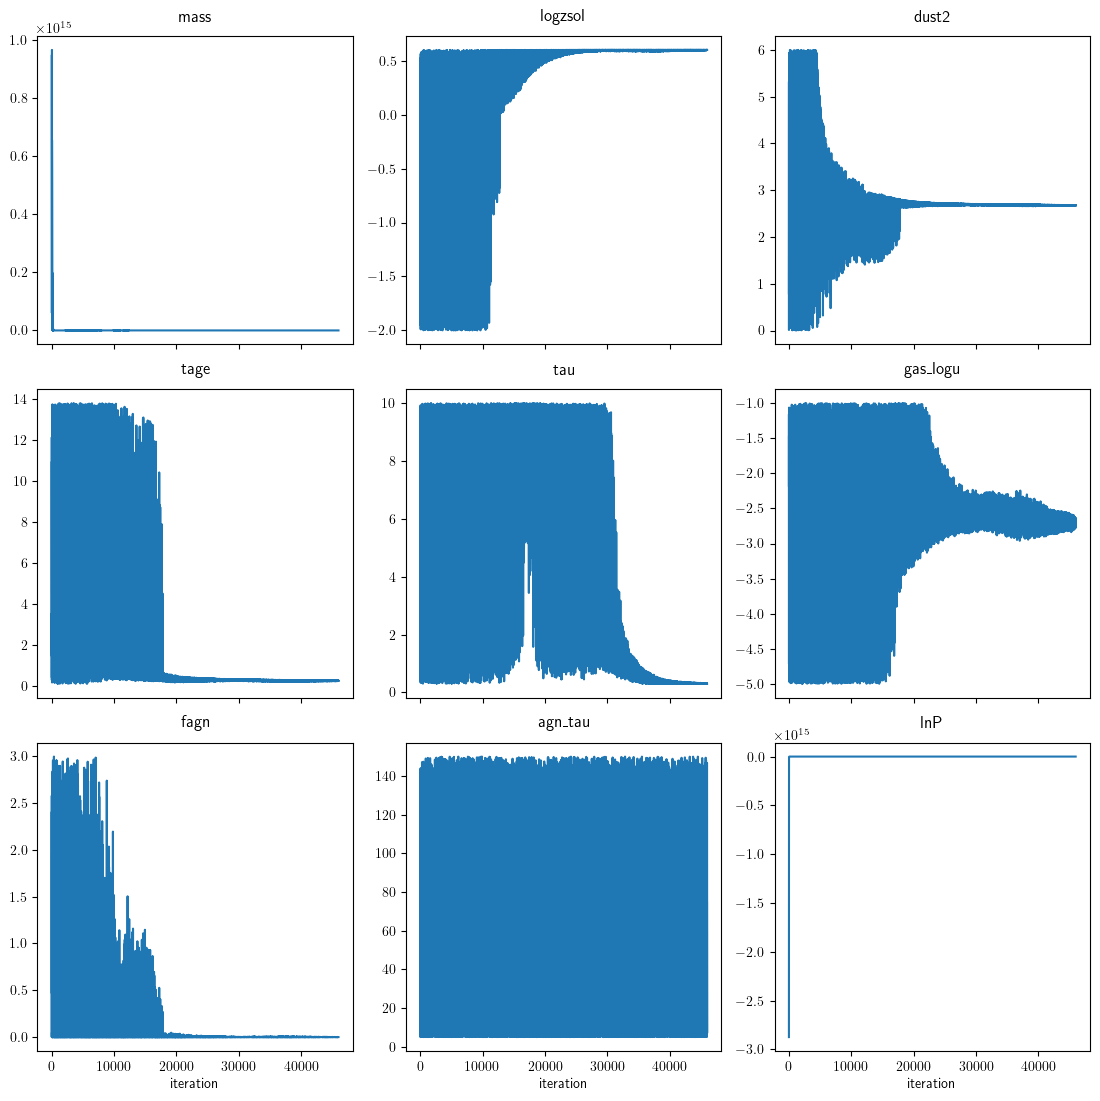

In [12]:
tracefig = reader.traceplot(out)

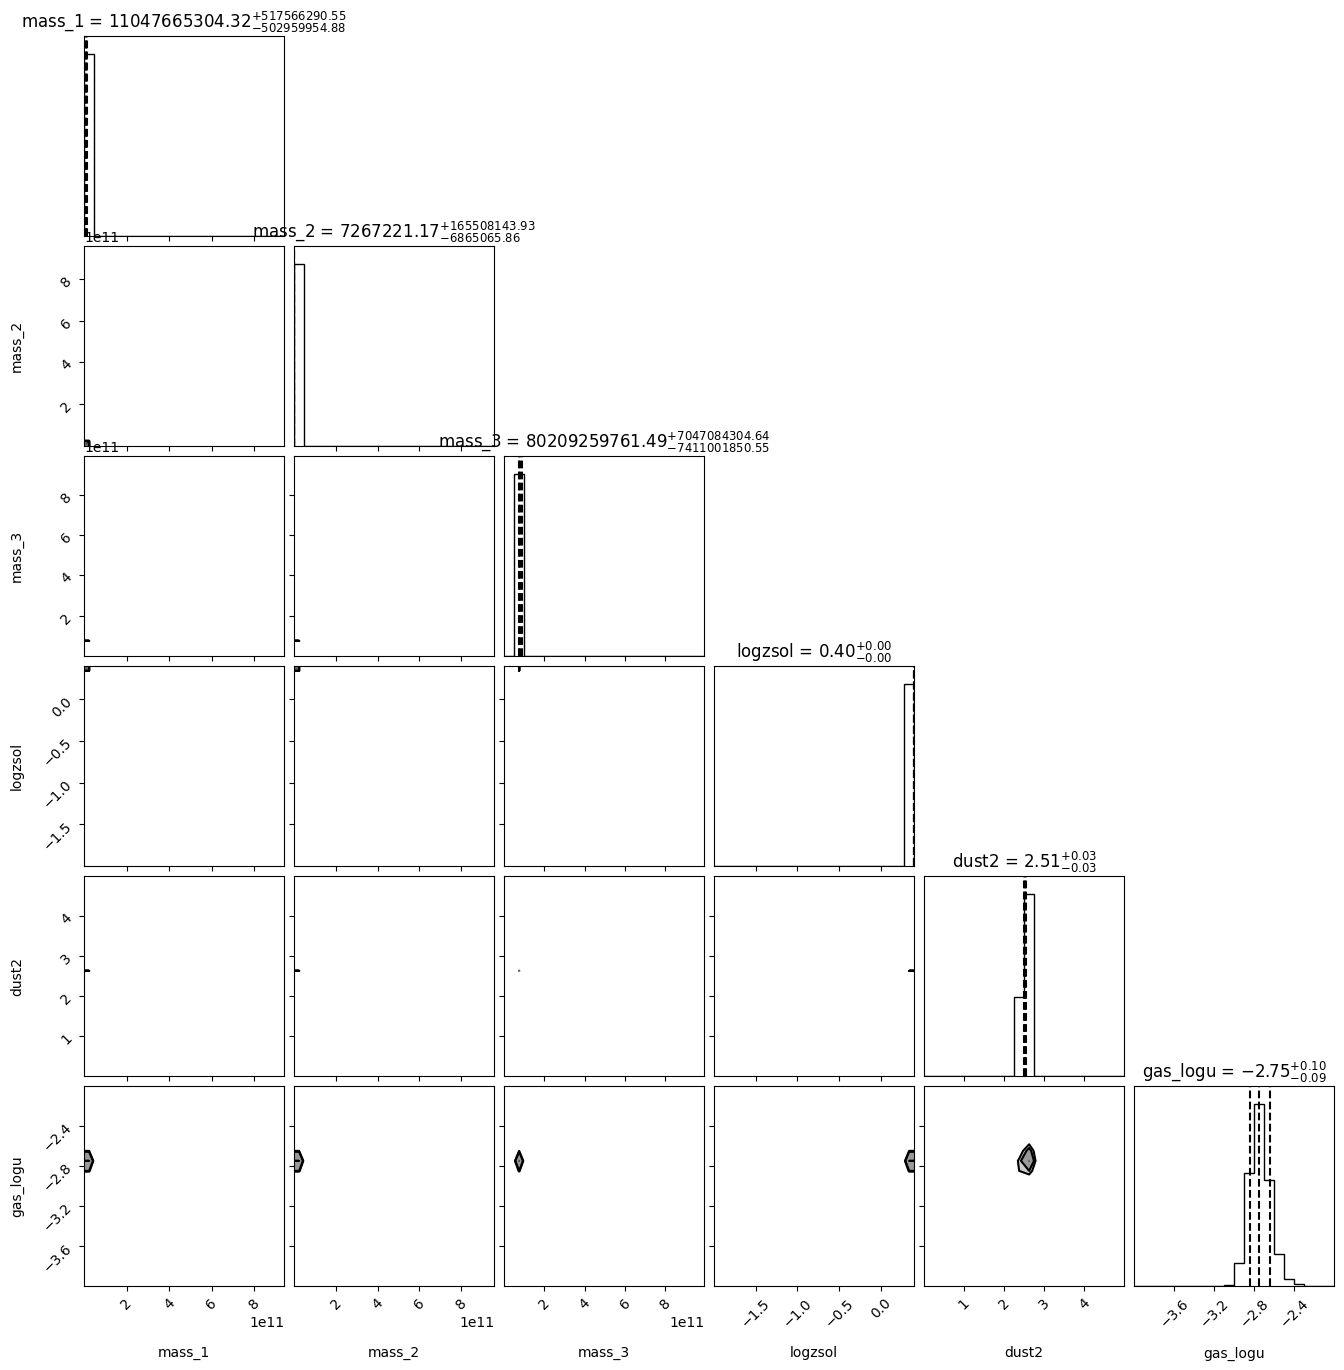

In [18]:
cornerfig = reader.subcorner(out,)

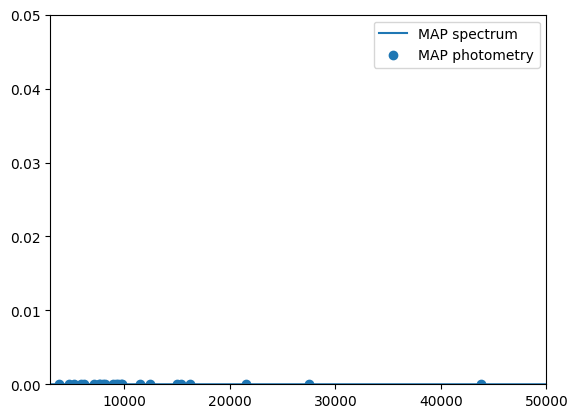

In [61]:
import matplotlib.pyplot as pl
best = out["bestfit"]
a = model.params["zred"] + 1
pl.plot(a * best["restframe_wavelengths"], best['spectrum'], label="MAP spectrum")
if out_obs['filters'] is not None:
    pwave = [f.wave_effective for f in out_obs["filters"]]
    pl.scatter(pwave, best['photometry'], label="MAP photometry")
plt.xlim(3e3, 5e4)
plt.ylim(0, 0.05)
plt.legend()
plt.show()

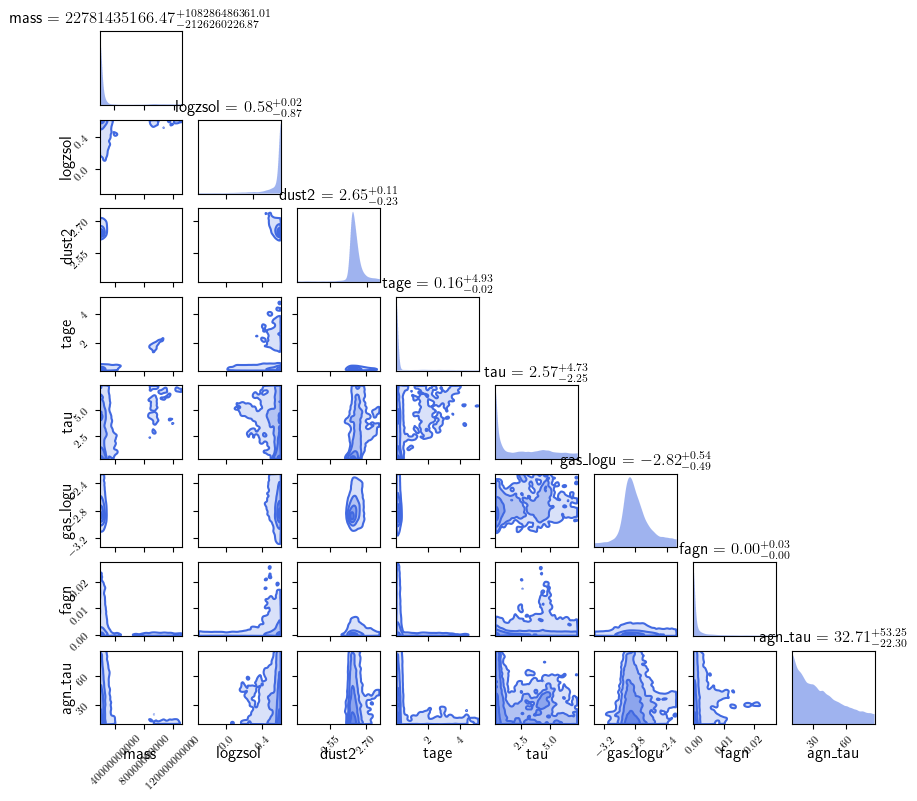

In [6]:
import matplotlib.pyplot as plt
from prospect.plotting import corner
nsamples, ndim = out["chain"].shape
cfig, axes = pl.subplots(ndim, ndim, figsize=(10,9))
axes = corner.allcorner(out["chain"].T, out["theta_labels"], axes, span=[0.68]*ndim, color="royalblue", show_titles=True)
# for ax in axes[:3, :].flatten():
#     ax.set_yscale('log')
# for ax in axes[:, :3].flatten():
#     ax.set_xscale('log')

plt.show()
from prospect.plotting.utils import best_sample
pbest = best_sample(out)
corner.scatter(pbest[:, None], axes, color="firebrick", marker="o")

Text(0, 0.5, '$\\chi_{\\rm best}$')

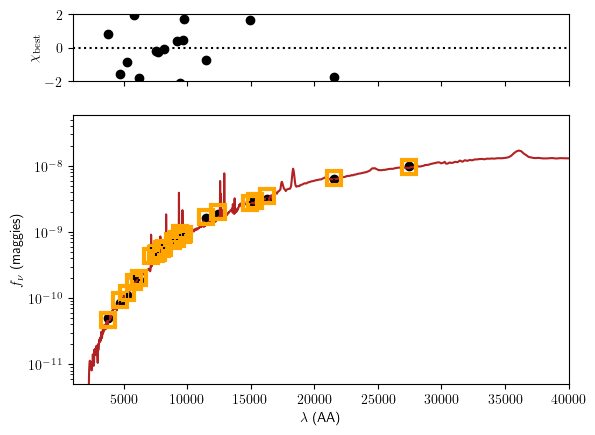

In [5]:
import matplotlib.pyplot as pl
import numpy as np
sfig, saxes = pl.subplots(2, 1, gridspec_kw=dict(height_ratios=[1, 4]), sharex=True)
ax = saxes[1]
pwave = np.array([f.wave_effective for f in out_obs["filters"]])
# plot the data
ax.plot(pwave, out_obs["maggies"], linestyle="", marker="o", color="k")
ax.errorbar(pwave,  out_obs["maggies"], out_obs["maggies_unc"], linestyle="", color="k", zorder=10)
ax.set_ylabel(r"$f_\nu$ (maggies)")
ax.set_xlabel(r"$\lambda$ (AA)")
ax.set_xlim(1e3, 4e4)
ax.set_ylim(out_obs["maggies"].min() * 0.1, out_obs["maggies"].max() * 5)
ax.set_yscale("log")

# get the best-fit SED
bsed = out["bestfit"]
ax.plot(bsed["restframe_wavelengths"] * (1+out_obs["redshift"]), bsed["spectrum"], color="firebrick", label="MAP sample")
ax.plot(pwave, bsed["photometry"], linestyle="", marker="s", markersize=10, mec="orange", mew=3, mfc="none")

ax = saxes[0]
chi = (out_obs["maggies"] - bsed["photometry"]) / out_obs["maggies_unc"]
ax.plot(pwave, chi, linestyle="", marker="o", color="k")
ax.axhline(0, color="k", linestyle=":")
ax.set_ylim(-2, 2)
ax.set_ylabel(r"$\chi_{\rm best}$")

# Combine fitting results from Bagpipes and Prospector

Bagpipes compute SFR in 0.1 Gyr

But Prospecter compute SFR in 0.001 Gyr

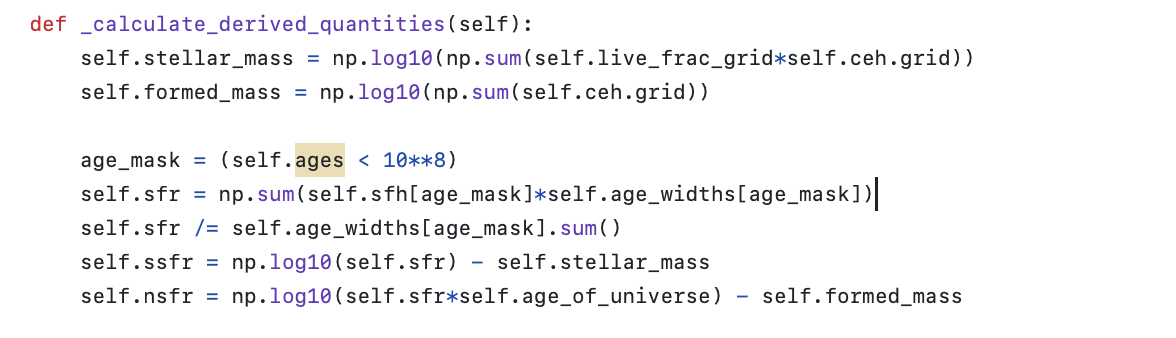

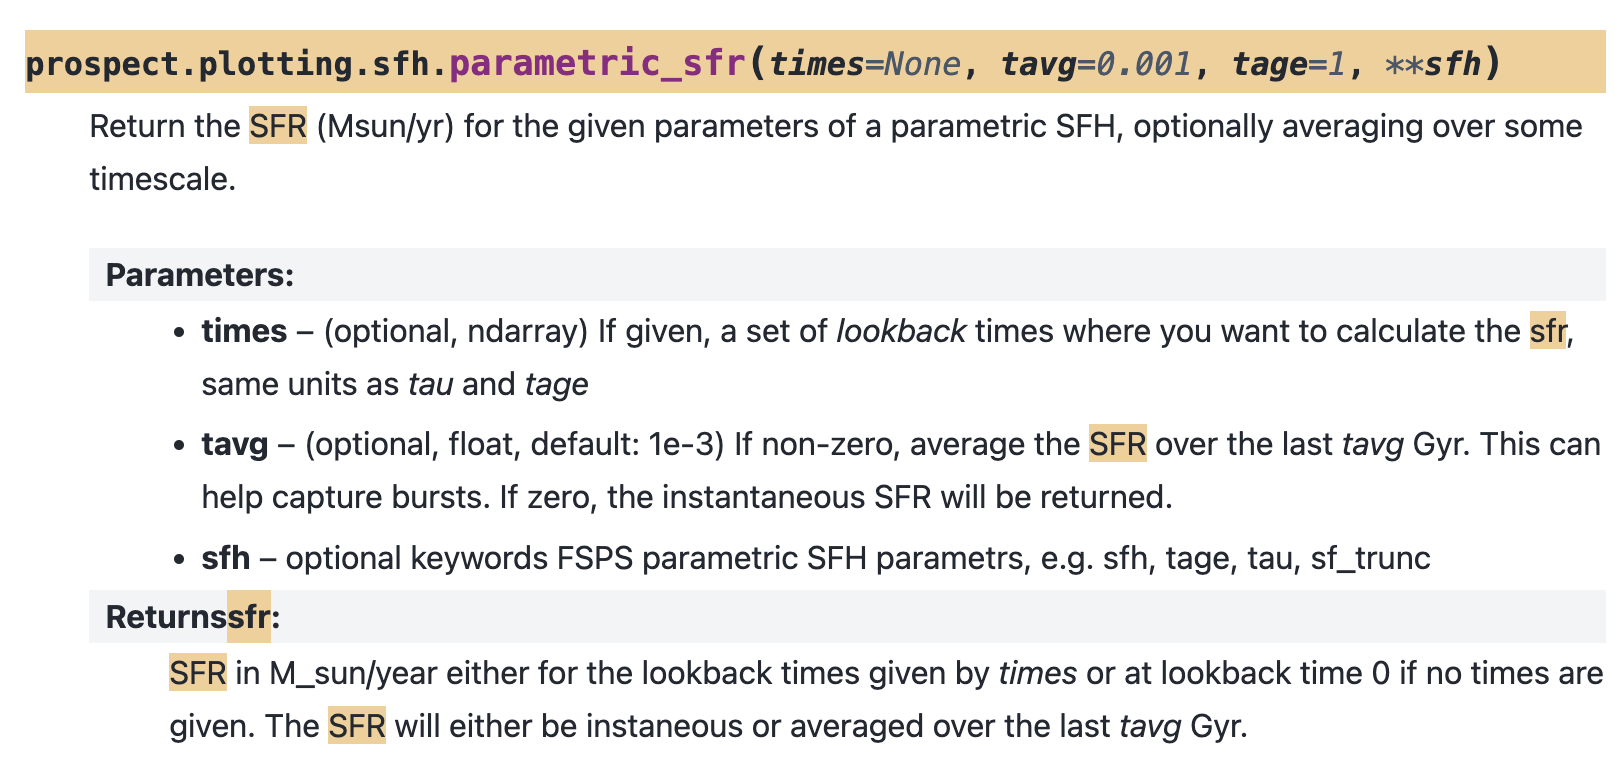

In [32]:
out['theta_labels']

['mass_1', 'mass_2', 'mass_3', 'logzsol', 'dust2', 'gas_logu']

----homo_ellipse_v1_dered----exponential----
:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=10.0,maxi=1000000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.6)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=6.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.1,maxi=13.8)
  tau: <class 'prospect.models.priors.TopHat'>(mini=0.3,maxi=10.0)
  gas_logu: <class 'prospect.models.priors.TopHat'>(mini=-5.0,maxi=-1.0)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.924] 
  sfh: [1] 
  imf_type: [2] 
  dust_type: [2] 
  add_neb_emission: [ True] 
  add_neb_continuum: [ True] 
  nebemlineinspec: [ True] 
  gas_logz: [0.] <function stellar_logzsol at 0x7f47fe64f5b0>
----homo_ellipse_v1_dered----delayed----
:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <cla

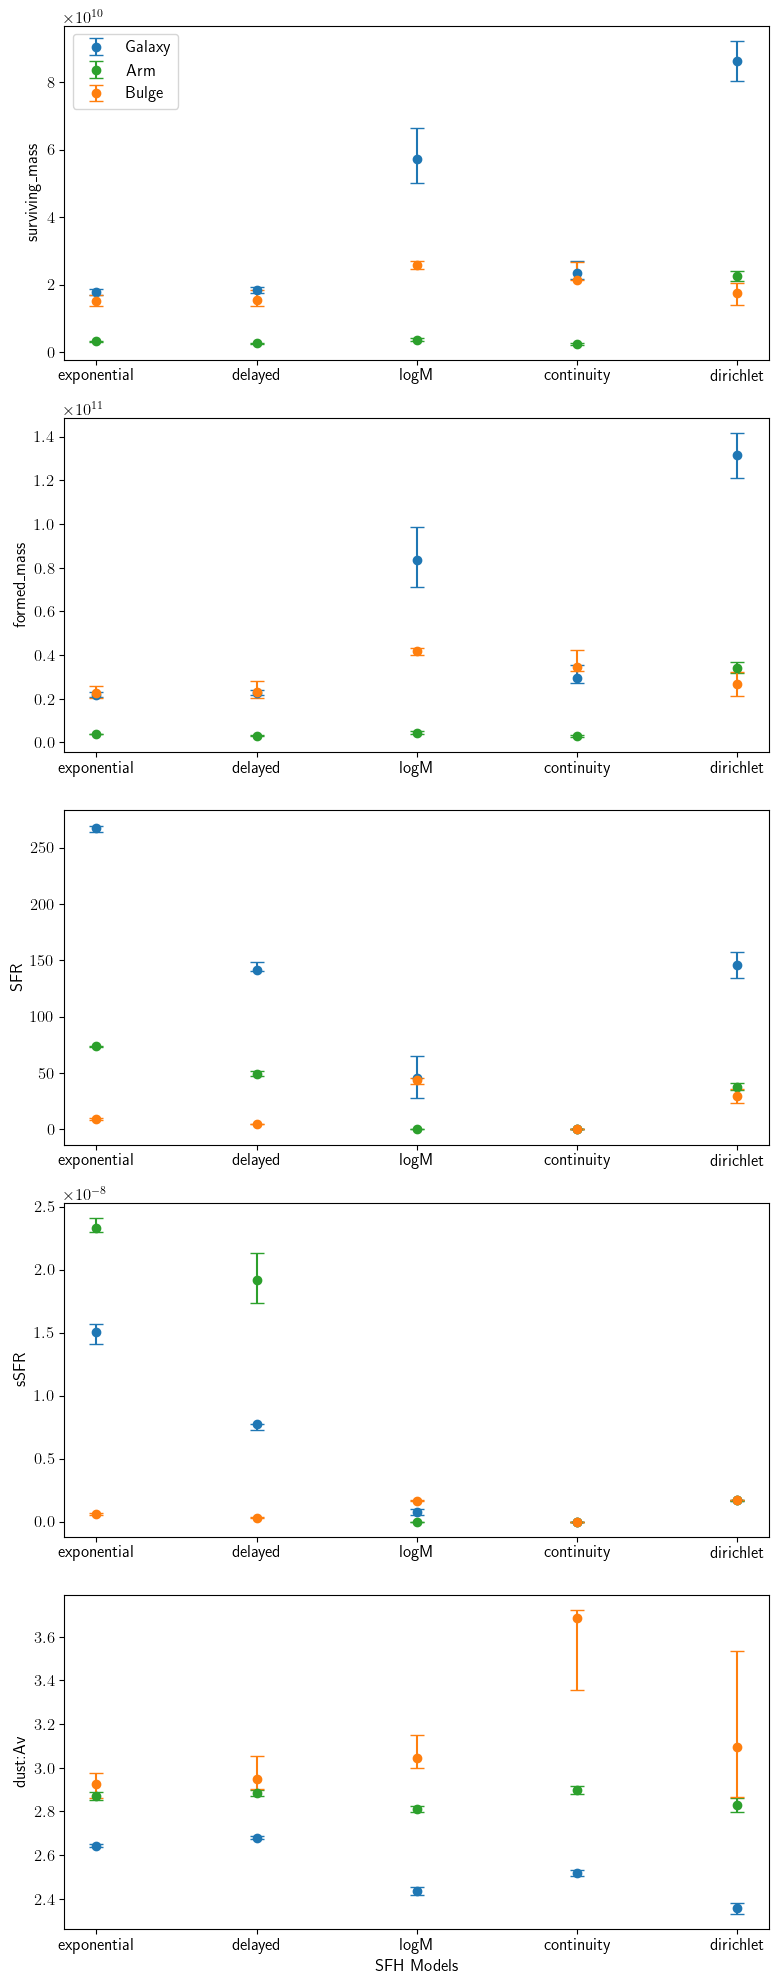

In [7]:
import plotting_Prospect as tools
results = tools.results_plot(versions=['homo_ellipse_v1_dered', 'space_homo_downleft_dered', 'space_homo_upright_dered'], SFH_models=['exponential', 'delayed', 'logM', 'continuity', 'dirichlet'], labels=["surviving_mass", "formed_mass", "SFR", "sSFR", "dust:Av"])

In [2]:
results

{'space_homo_downleft_dered': {'mass': {},
  'SFR': {'24Jan24-15.13_result': [0.000883523425307845,
    0.0020382623359789945,
    0.011465580021772797]},
  'sSFR': {'24Jan24-15.13_result': [1.483644391783014e-13,
    2.6368372324701574e-13,
    1.1964292681478307e-12]},
  'dust:Av': {'24Jan24-15.13_result': [2.796000875055138,
    2.823094916395868,
    2.8569963375373484]}}}

:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=1.0,maxi=1000000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.4)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=5.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.1,maxi=13.8)
  tau: <class 'prospect.models.priors.TopHat'>(mini=0.3,maxi=10.0)
  gas_logu: <class 'prospect.models.priors.TopHat'>(mini=-4.0,maxi=-2.0)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.924] 
  sfh: [4] 
  imf_type: [2] 
  dust_type: [2] 
  add_neb_emission: [ True] 
  add_neb_continuum: [ True] 
  nebemlineinspec: [ True] 
  gas_logz: [0.] <function stellar_logzsol at 0x7f2f14b36c20>
:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=[100000. 100000. 100000.],maxi=[1.e+12 1.e

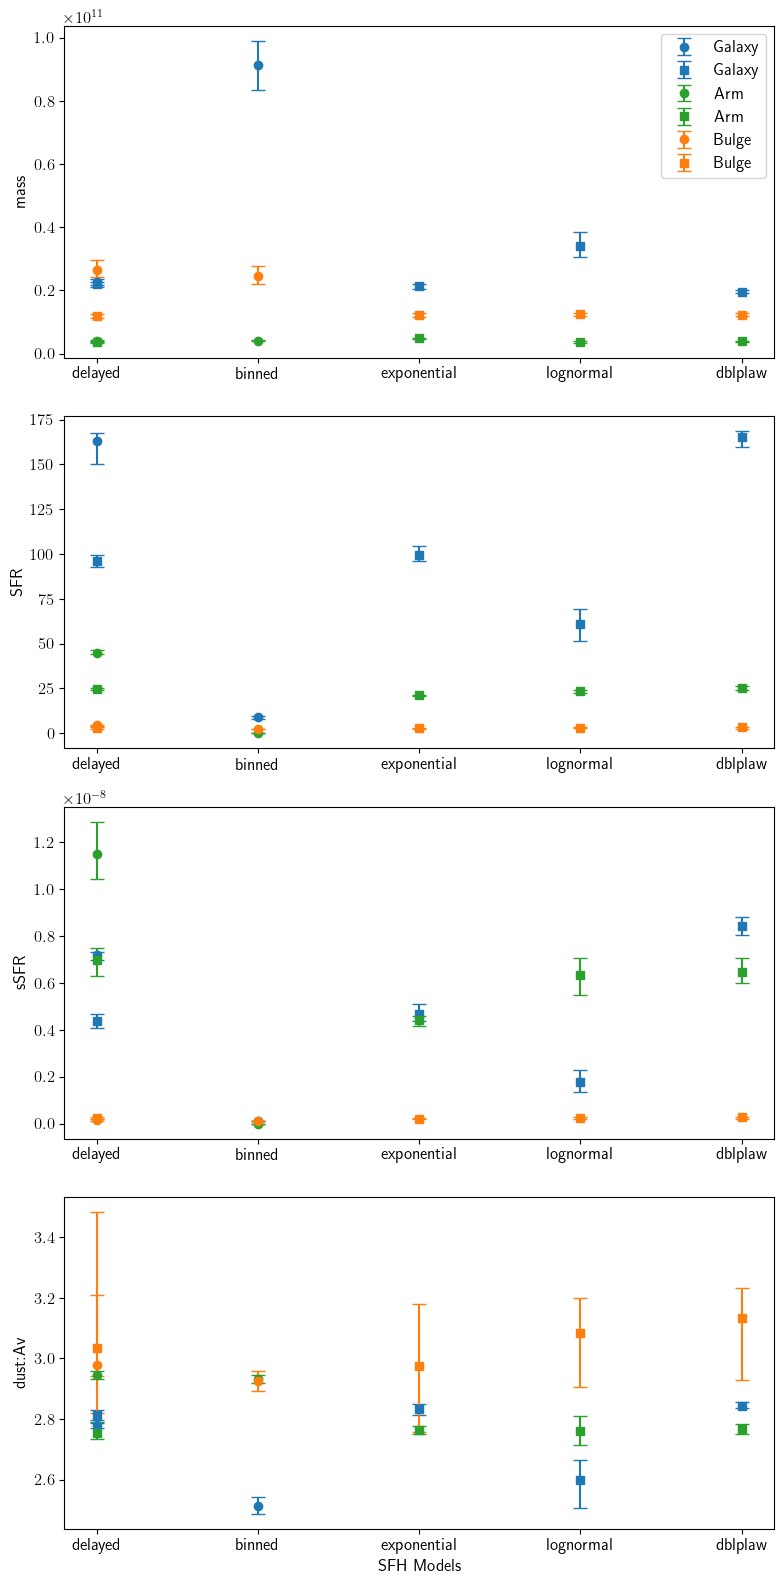

In [30]:
import plotting_Prospect as tools
results = tools.results_plot(pipes_results=pipes_results)

In [7]:
results

{'homo_ellipse_v1': {'mass': {'delayed': [21549421189.726776,
    22656446761.697403,
    23716459461.11437]},
  'SFR': {'delayed': [149.98288679207994,
    163.01493027425767,
    167.7260991915512],
   'binned': [8.088695323437813, 8.912139973498633, 9.695149340680542]},
  'sSFR': {'delayed': [6.959949665078757e-09,
    7.1950792632606405e-09,
    7.072139054590159e-09],
   'binned': [9.705266019791385e-11,
    9.765209936308384e-11,
    9.793638970496017e-11]},
  'dust2': {'delayed': [2.7709865869031742,
    2.7798023654130413,
    2.7883413900512424],
   'binned': [2.4861419183458224, 2.5133635796340497, 2.5409905049187222]}},
 'space_homo_downleft': {'mass': {'delayed': [3644213758.2588425,
    3907050051.548163,
    4260383412.402744]},
  'SFR': {'delayed': [45.808226606040954,
    44.88518144802952,
    43.08573878486729],
   'binned': [4.979586946195471e-05,
    0.001191096648832073,
    0.029317569581065524]},
  'sSFR': {'delayed': [1.2570126135500769e-08,
    1.14882535047749

In [4]:
from prospect.models import transforms
transforms.zred_to_agebins(zred=1., agebins=[[ 0., 8.],[ 8., 9.],[ 9., 10.]])

array([[0.        , 8.        ],
       [8.        , 9.        ],
       [9.        , 9.77248515]])

In [5]:
pipes_results

{'homo_ellipse_v1': {'stellar_mass': {'exponential': array([10.32888846, 10.31277423, 10.34401114]),
   'delayed': array([10.34300278, 10.32649402, 10.35908528]),
   'lognormal': array([10.53402868, 10.48817362, 10.58869041]),
   'dblplaw': array([10.2933086 , 10.28137151, 10.30148317])},
  'SFR': {'exponential': array([ 99.12674653,  95.59337822, 104.21212809]),
   'delayed': array([96.02964868, 92.72152367, 98.90343817]),
   'lognormal': array([60.92569558, 51.07337458, 69.31024885]),
   'dblplaw': array([164.8291945 , 159.70942391, 168.51991003])},
  'sSFR': {'exponential': array([-8.33309989, -8.36283874, -8.2953368 ]),
   'delayed': array([-8.36014705, -8.39170876, -8.33189699]),
   'lognormal': array([-8.74839542, -8.88126638, -8.64927366]),
   'dblplaw': array([-8.07683253, -8.09706742, -8.05599865])},
  'dust:Av': {'exponential': array([2.83259887, 2.81455774, 2.85090951]),
   'delayed': array([2.81276104, 2.79886212, 2.82877947]),
   'lognormal': array([2.59434511, 2.49968646,

In [5]:
def adjust_agebins(nbin):
    assert (nbin>6)&(nbin<10), "The number of agebins should be larger than 6 and less than 9."
    agelims = [0, np.log10(30*1e6), np.log10(100*1e6), np.log10(330*1e6), np.log10(1.1*1e9), np.log10(3.6*1e9), np.log10(11.7*1e9), np.log10(13.7*1e9)]
    attachlims = [np.log10(3*1e6), np.log10(10*1e6)]
    for i in range(nbin-7):
        agelims.insert(1, attachlims[-1+i])
    agebins = np.array([agelims[:-1], agelims[1:]]).T
    return agelims, agebins

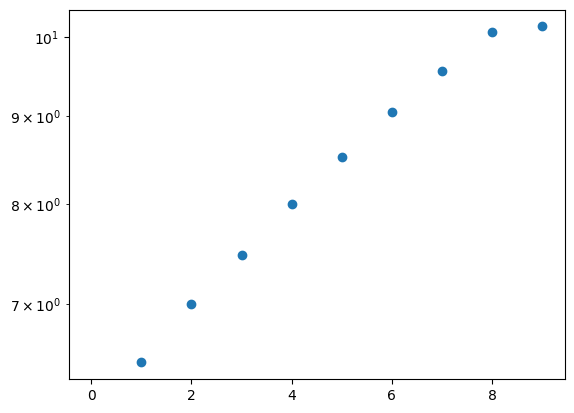

In [15]:
plt.scatter(np.arange(10), adjust_agebins(9)[0])
plt.yscale('log')

In [19]:
from astropy.cosmology import WMAP9 as cosmo
def get_agebins(nbin):
    assert (nbin>6)&(nbin<10), "The number of agebins should be larger than 6 and less than 9."
    #following the 7 agebins in the paper: https://ui.adsabs.harvard.edu/abs/2019ApJ...876....3L
    agelims = [0, 30*1e6, 100*1e6, 330*1e6, 1.1*1e9, 3.6*1e9, 11.7*1e9, 13.7*1e9]
    #add agebins in the front by myself
    attachlims = [3*1e6, 10*1e6]
    for i in range(nbin-7):
        agelims.insert(1, attachlims[-1+i])
    agebins = np.array([agelims[:-1], agelims[1:]]).T
    agebins[0][0] = 1
    return agelims, np.log10(agebins) #agelims in yr, agebins in log10(yr)
def adjust_agebins_with_zred(agelims, zred):
    tuniv = cosmo.lookback_time(zred).value*1e9 #yr
    agelims = np.asarray(agelims)
    new_agelims = agelims*(agelims.max()-tuniv)/agelims.max()
    new_agebins = np.array([new_agelims[:-1], new_agelims[1:]]).T
    new_agebins[0][0] = 1
    return new_agelims, np.log10(new_agebins) #agelims in yr, agebins in log10(yr)

In [20]:
adjust_agebins_with_zred(get_agebins(8)[0], 0.924)

(array([0.00000000e+00, 4.50765865e+06, 1.35229760e+07, 4.50765865e+07,
        1.48752735e+08, 4.95842452e+08, 1.62275711e+09, 5.27396062e+09,
        6.17549235e+09]),
 array([[0.        , 6.65395102],
        [6.65395102, 7.13107228],
        [7.13107228, 7.65395102],
        [7.65395102, 8.17246496],
        [8.17246496, 8.69534371],
        [8.69534371, 9.21025352],
        [9.21025352, 9.72213688],
        [9.72213688, 9.79067159]]))

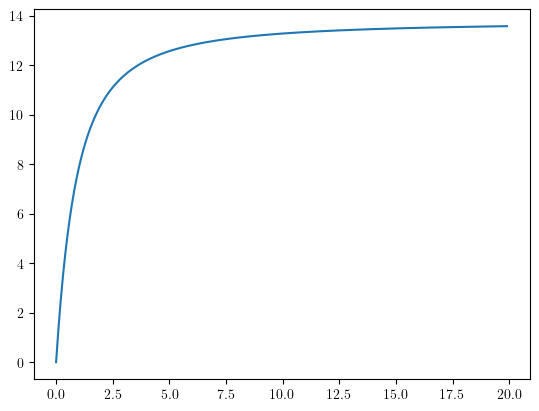

In [39]:
zs = np.arange(0, 20, 0.1)
Gyrs = cosmo.lookback_time(zs).value
plt.plot(zs, Gyrs)

In [4]:
import astropy.units as u
(10**8.37962604*u.yr).to(u.Gyr)

<Quantity 0.23967682 Gyr>

In [15]:
np.log10(1)

0.0

In [10]:
cosmo.lookback_time(100000)

<Quantity 13.76889904 Gyr>

In [14]:
np.log10(cosmo.lookback_time(0.924).value*1e9)-np.log10(13.7*1e9)
np.log10(-(cosmo.lookback_time(0.924).value*1e9-13.7*1e9))

9.790671588194673

In [24]:
[0, np.log10(30*1e6), np.log10(100*1e6), np.log10(330*1e6), np.log10(1.1*1e9), np.log10(3.6*1e9), np.log10(11.7*1e9), np.log10(13.7*1e9)]

[0,
 7.477121254719663,
 8.0,
 8.518513939877888,
 9.041392685158225,
 9.556302500767288,
 10.068185861746162,
 10.136720567156408]

In [10]:
for version in pipes_results.keys():
    pipes_results[version]['mass'] = pipes_results[version].pop('stellar_mass')

In [12]:
for version in pipes_results.keys():
    for sfh in pipes_results[version]['mass'].keys():
        pipes_results[version]['mass'][sfh] = 10**pipes_results[version]['mass'][sfh]

In [14]:
for version in pipes_results.keys():
    for sfh in pipes_results[version]['sSFR'].keys():
        pipes_results[version]['sSFR'][sfh] = 10**pipes_results[version]['sSFR'][sfh]

In [21]:
from astropy.cosmology import WMAP9 as cosmo
import numpy as np
def get_agebins(nbin):
    assert (nbin>6)&(nbin<10), "The number of agebins should be larger than 6 and less than 9."
    #following the 7 agebins in the paper: https://ui.adsabs.harvard.edu/abs/2019ApJ...876....3L
    agelims = [0, np.log10(30*1e6), np.log10(100*1e6), np.log10(330*1e6), np.log10(1.1*1e9), np.log10(3.6*1e9), np.log10(11.7*1e9), np.log10(13.7*1e9)]
    #add agebins in the front by myself
    attachlims = [np.log10(3*1e6), np.log10(10*1e6)]
    for i in range(nbin-7):
        agelims.insert(1, attachlims[-1+i])
    agebins = np.array([agelims[:-1], agelims[1:]]).T
    return agelims, agebins
def adjust_agebins_with_zred(agelims, zred):
    tuniv = np.log10(cosmo.lookback_time(zred).value*1e9)
    agelims = np.asarray(agelims)
    new_agelims = agelims*(agelims.max()-tuniv)/agelims.max()+tuniv
    assert new_agelims.min() == tuniv
    new_agebins = np.array([new_agelims[:-1], new_agelims[1:]]).T
    return new_agelims, new_agebins

In [23]:

np.log10(11.7*1e9)

10.068185861746162

In [20]:
cosmo.lookback_time(0.08)

<Quantity 1.06682562 Gyr>

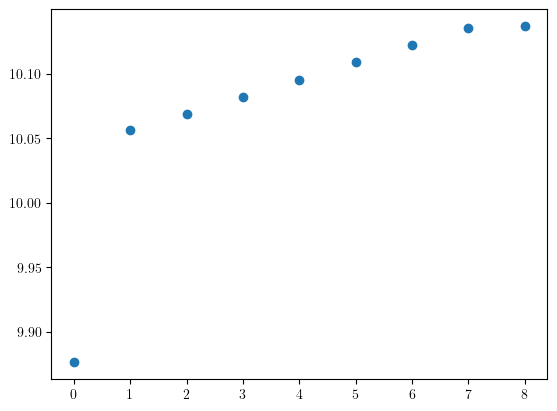

In [31]:
plt.scatter(np.arange(9), adjust_agebins_with_zred(get_agebins(8)[0], 0.924)[0])
# plt.yscale('log')

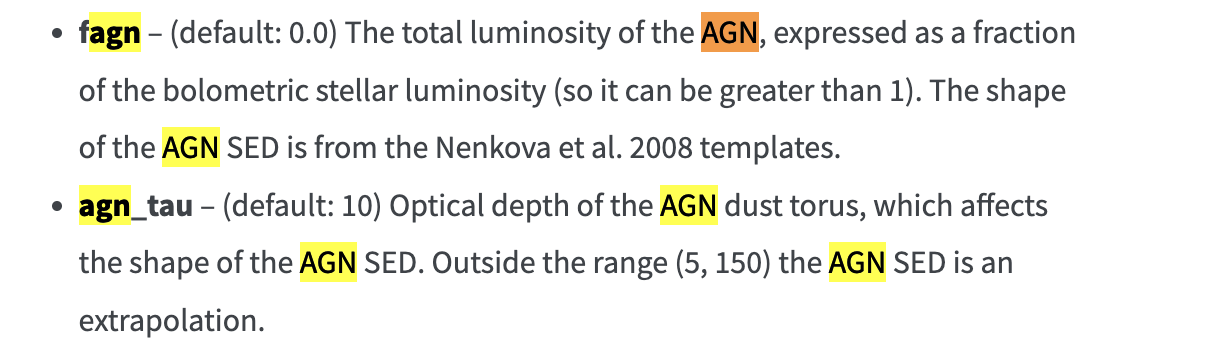